In [1]:
import sys
sys.path.append('../..')

In [2]:
import numpy

def Dx(image: numpy.ndarray) -> numpy.ndarray:

    nb_rows, nb_cols = numpy.shape(image)
    image_derivated = numpy.zeros(shape=(nb_rows, nb_cols))

    image_derivated[:, 1:nb_cols] = \
        image[:, 1:nb_cols] - image[:, 0:nb_cols-1]

    image_derivated[:, 0] = image[:, 0] - image[:, nb_cols-1]

    return image_derivated

def Dy(image: numpy.ndarray) -> numpy.ndarray:
    
    nb_rows, nb_cols = numpy.shape(image)
    image_derivated = numpy.zeros(shape=(nb_rows, nb_cols))
    
    image_derivated[1:nb_rows, :] = \
        image[1:nb_rows, :] - image[0:nb_rows-1, :]

    image_derivated[0, :] = image[0, :] - image[nb_rows-1, :]

    return image_derivated

def Dxt(image: numpy.ndarray) -> numpy.ndarray:

    nb_rows, nb_cols = numpy.shape(image)
    image_derivated = numpy.zeros(shape=(nb_rows, nb_cols))
    
    image_derivated[:, 0:nb_cols-1] = \
        image[:, 0:nb_cols-1] - image[:, 1:nb_cols]

    image_derivated[:, nb_cols-1] = image[:, nb_cols-1] - image[:, 0]

    return image_derivated


def Dyt(image: numpy.ndarray) -> numpy.ndarray:
    
    nb_rows, nb_cols = numpy.shape(image)
    image_derivated = numpy.zeros(shape=(nb_rows, nb_cols))
    
    image_derivated[0:nb_rows-1, :] = \
        image[0:nb_rows-1, :] - image[1:nb_rows, :]

    image_derivated[nb_rows-1, :] = image[nb_rows-1, :] - image[0, :]

    return image_derivated

def shrink2_v1(x, y, lamda):

    s = numpy.sqrt(x*numpy.conj(x)+y*numpy.conj(y))
    ss = s-lamda
    ss = ss*(ss>0)

    s=s+lamda
    ss=ss/s

    xs=ss*x
    ys=ss*y

    return xs, ys

def shrink2_v2(x, y, lamda):

    s = x + y*1j
    ss = numpy.sign(s) * numpy.where(0 < numpy.abs(s)-lamda, numpy.abs(s)-lamda, 0)
    xs=numpy.real(ss)
    ys=numpy.imag(ss)

    return xs, ys

## CMST_SegMain

In [3]:
import matplotlib.pyplot

import lasp.filters
import lasp.noise
import scipy.signal
import scipy.io

Img_original = numpy.array(
    matplotlib.pyplot.imread('Boats.bmp'),
    dtype=numpy.double
)

h = lasp.filters.gaussian_filter(size=7, sigma=3)
Img_blurred = numpy.array(
    scipy.signal.convolve2d(Img_original, h, mode='same'),
    dtype=numpy.double
)

Img_noised = lasp.noise.awgn(Img_blurred, snr=20)



Img = numpy.array(
    scipy.signal.convolve2d(Img_noised, h, mode='same'),
    dtype=numpy.double
)

Img = Img - numpy.min(Img)
Img = Img / numpy.max(Img)

LAMBDA = 100
MU = 1
SIGMA = 2

import pathlib
import lasp.io
path = pathlib.Path('PyVsMat/CMST_SegDeblur')
lasp.io.save(Img, path / 'input.png')
lasp.io.save(h, path / 'kernel.png')
scipy.io.savemat(path / 'kernel.mat', {'a' : h})
# print(h)
# print(matplotlib.pyplot.imread(path / 'kernel.png'))

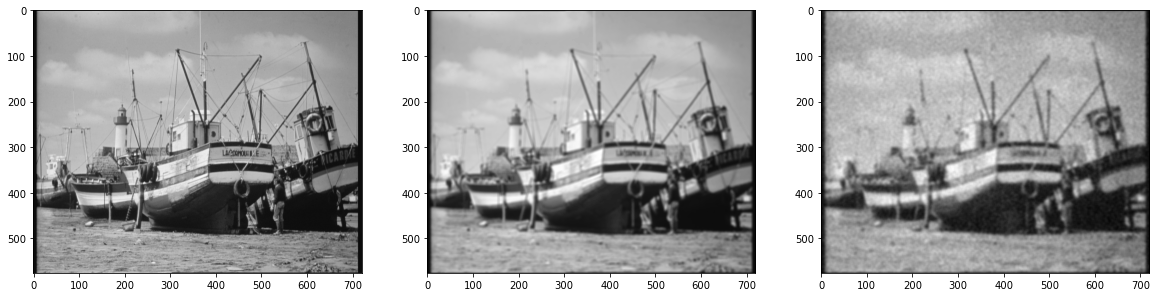

In [4]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.imshow(Img_original, cmap='gray')
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.imshow(Img_blurred, cmap='gray')
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.imshow(Img, cmap='gray')


In [5]:
import numpy
import numpy.linalg

nb_rows, nb_cols = Img.shape
# INitialization
u = numpy.copy(Img) 
wx=numpy.zeros_like(Img)
wy=numpy.zeros_like(Img)
bx=numpy.zeros_like(Img)
by=numpy.zeros_like(Img)

# Build kernel
uker = numpy.zeros_like(Img)
uker[0, 0] = 4
uker[0, 1] = -1
uker[1, 0] = -1
uker[nb_rows-1, 0] = -1
uker[0, nb_cols-1] = -1

# Construct the deblur operator
# flt_blur = numpy.array(numpy.load('motion_15_90.npy'))
flt_blur = h
xLen_flt, yLen_flt = flt_blur.shape
xLen, yLen = Img.shape
ope_blur = numpy.zeros((xLen, yLen))
ope_blur[0:xLen_flt, 0:yLen_flt] = flt_blur

# Shift deblur operator
xLen_flt_1 = int(numpy.floor(xLen_flt/2))
yLen_flt_1 = int(numpy.floor(yLen_flt/2))
# ope_blur_1 = numpy.pad()
# ope_blur_1 = ope_blur_1[xLen_flt_1+1:xLen+xLen_flt_1+1, yLen_flt_1+1:yLen+yLen_flt_1]
ope_blur_1 = numpy.roll(ope_blur, (xLen_flt_1, yLen_flt_1), [0, 1])


uker = LAMBDA*numpy.conj(numpy.fft.fft2(ope_blur_1))*numpy.fft.fft2(ope_blur_1)+(MU+SIGMA)*numpy.fft.fft2(uker)

rhs1fft = LAMBDA*numpy.conj(numpy.fft.fft2(ope_blur_1))*numpy.fft.fft2(Img)


for i in range(0, 300):

    rhs2 = SIGMA*Dxt(wx-bx)+SIGMA*Dyt(wy-by)
    rhsfft = rhs1fft + numpy.fft.fft2(rhs2)

    u0=numpy.copy(u)
    
    u = numpy.real(numpy.fft.ifft2(rhsfft / uker))

    err = numpy.linalg.norm(u-u0, 'fro') / numpy.linalg.norm(u, 'fro')

    if i%10 == 0:
        print('Iterations: {} ! \t error is: {}'.format(i, err))

    if err < 10**(-4):
        break
    
    temp1 = Dx(u)+bx
    temp2 = Dy(u)+by

    # wx, wy = shrink2_v1(temp1, temp2, 1/SIGMA)
    wx, wy = shrink2_v1(temp1, temp2, 1/SIGMA)

    bx=bx+Dx(u)-wx
    by=by+Dy(u)-wy

min_u = numpy.min(u)
max_u = numpy.max(u)
u = (u-min_u) / (max_u-min_u)


# mat 5x5 alétaoire
# load(mat)
# difference entre les 2


Iterations: 0 ! 	 error is: 0.4561629129952279
Iterations: 10 ! 	 error is: 0.0023569090897063378
Iterations: 20 ! 	 error is: 0.0008322696308115278
Iterations: 30 ! 	 error is: 0.0004136924645401366
Iterations: 40 ! 	 error is: 0.00023936067446596174
Iterations: 50 ! 	 error is: 0.0001601123815018856
Iterations: 60 ! 	 error is: 0.00011266872591193519


In [6]:
# Iterations: 0 ! 	 error is: 0.4566358295708961
# Iterations: 10 ! 	 error is: 0.0023263219693378354
# Iterations: 20 ! 	 error is: 0.0008205233669866695
# Iterations: 30 ! 	 error is: 0.0004013006642565295
# Iterations: 40 ! 	 error is: 0.00023244740450736892
# Iterations: 50 ! 	 error is: 0.00015409033190974468
# Iterations: 60 ! 	 error is: 0.000107980793226402

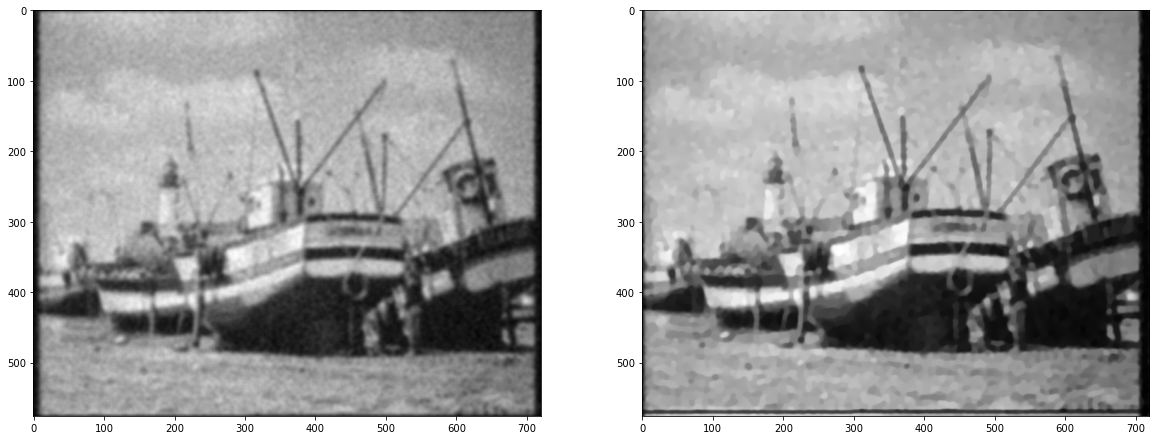

In [7]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.imshow(Img, cmap='gray')
matplotlib.pyplot.subplot(1, 2, 2)

matplotlib.pyplot.imshow(numpy.real(u), cmap='gray')
lasp.io.save(u, path / 'output.png')

1.4668315950761013e-07

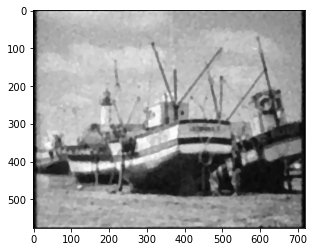

In [8]:
import scipy.io
a = scipy.io.matlab.loadmat('matlab_res/output_deblurred.mat')
mat_res = numpy.array(a['uu'])
matplotlib.pyplot.imshow(mat_res, cmap='gray')
numpy.max(numpy.abs(mat_res-u))
numpy.min(numpy.abs(mat_res-u))

In [9]:
import lasp.metrics
lasp.metrics.mean_squared_error(mat_res, u)

0.019909403404061582

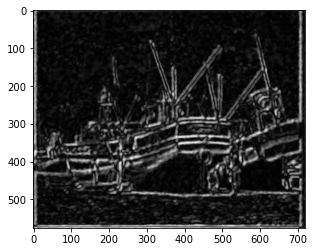

In [10]:
matplotlib.pyplot.imshow(numpy.abs(mat_res-u), cmap='gray')